In [105]:
"theatre|cafe|nightclub|kindergarten|doctors|fuel|bank|library|cinema|restaurant|atm|bar|fast_food|pharmacy|veterinary|taxi|brothel|university|police|events_venue|college|car_rental|clinic|community_centre|courier|food_court|social_facility|parking_space|hospital|waste_disposal|parcel_locker|charging_station|coworking_space|meeting_point|motorcycle_parking|childcare|social_centre|music_venue|healthcare|waste_transfer_station|casino|fire_station|student_accommodation|retail|prison|nursing_home|events_centre|exhibition_centre|conference_centre|biergarten|bus_station",


('theatre|cafe|nightclub|kindergarten|doctors|fuel|bank|library|cinema|restaurant|atm|bar|fast_food|pharmacy|veterinary|taxi|brothel|university|police|events_venue|college|car_rental|clinic|community_centre|courier|food_court|social_facility|parking_space|hospital|waste_disposal|parcel_locker|charging_station|coworking_space|meeting_point|motorcycle_parking|childcare|social_centre|music_venue|healthcare|waste_transfer_station|casino|fire_station|student_accommodation|retail|prison|nursing_home|events_centre|exhibition_centre|conference_centre|biergarten|bus_station',)

work: coworking_space, meeting_point, conference_centre, 
bars/restaurants:cafe, nightclub, restaurant, bar, fast_food, brothel, food_court, biergarten
greenspace: land area of suburb
cost of living: affordability into accnt (People want to make the most of lower housing cost options, while still having secure working opportunities)
median rental house price?
education: best school score in the isochrone and also count of schools and universities with tags; kindergarten, library, university, college, student_accommodation, 
health services: doctors, pharmacy, veterinary, clinic, hospital, healthcare, 
proximity to transport stops: 
safety: police, prison(negative affecting)
entertainment/social: not as much weighted; theatre, cinema, events_venue, social_facility, community_centre,  social_centre, music_venue, casino, retail, events_centre, exhibition_centre
service: fuel, bank, atm, taxi, car_rental, courier, parking_space, waste_disposal, parcel_locker, charging_station, motorcycle_parking, childcare, waste_transfer_station(negative affecting), fire_station, bus_station

Livability Equation
(L = 0.18,\hat{W} + 0.12,\hat{E} + 0.10,\hat{G} + 0.12,\hat{C} + 0.10,\hat{Ed} + 0.12,\hat{H} + 0.08,\hat{T} + 0.10,\hat{S} + 0.08,\hat{Sv} - 0.10,\hat{N})

Positive pillars use min–max scaled scores (\hat{x} \in [0,1]) for the isochrone around each suburb:
W: work density (coworking_space, meeting_point, conference_centre, etc.)
E: food/nightlife (cafe, nightclub, restaurant, bar, fast_food, brothel, food_court, biergarten)
G: greenspace share (e.g., % public green land)
C: affordability (inverse of median rent/price)
Ed: education access (schools, universities, libraries, student_accommodation)
H: health services (doctors, pharmacy, veterinary, clinic, hospital, healthcare)
T: transport stops within reach (bus_station, taxi, car_rental, etc.)
S: safety presence (police vs. crime proxies)
Sv: everyday services (fuel, bank, atm, parcel_locker, charging_station, etc.)
Negative pillar (\hat{N}) captures detractors (waste_transfer_station, prison, heavy_waste facilities). Count or area is scaled the same way and subtracted.
How to Read It
The weights follow your earlier intuition: work, affordability, and health matter most (0.12–0.18 each); education, safety, and food/nightlife are mid-tier (0.10–0.12); transport and services keep convenience in view (0.08); detractors get a negative weight to reduce the final index when undesirable features dominate. Because every subscore is normalized, (L) lives on roughly ([-0.10, 1.0]), making comparisons straightforward.

Suggested Next Steps

Re-check weight choices with team/user research or sensitivity analysis.
Confirm each subscore’s normalization window (city-wide vs. suburb-only).
Add columns to notebooks/liveability.ipynb calculating these pillars and the final (L); visualize quartiles or top suburbs once ready.

In [106]:
import pandas as pd
from shapely import wkt
from utils.preprocess import PreprocessUtils
import numpy as np

In [107]:
def merge_on_suburb(column, data, destination):
    """ 
    A function to merge on suburb when they are of different forms
    Takes the average of combo suburbs - so only works for numeric data
    """
    # incoming dataset needs to have brackets/ extra info removed
    # also ensure lower case
    data["suburb"] = data["suburb"].str.replace(r"\s*\([^)]*\)", "", regex=True)
    data["suburb"] = data['suburb'].str.lower()

    # extra adjustments needed to match specific formatting
    data["suburb"] = data["suburb"].replace("brunswick west", "west brunswick")
    data["suburb"] = data["suburb"].replace("brunswick east", "east brunswick")
    data["suburb"] = data["suburb"].replace("st kilda east", "east st kilda")
    data["suburb"] = data["suburb"].replace("st kilda west", "west st kilda")
    data["suburb"] = data["suburb"].replace("hawthorn east", "east hawthorn")
    data["suburb"] = data["suburb"].replace("east bendigo", "bendigo east")

    data["suburb"] = data["suburb"].replace("mount martha", "mt martha")
    data["suburb"] = data["suburb"].replace("mount eliza", "mt eliza")

    data["suburb"] = data["suburb"].replace("wangaratta", "wanagaratta")
    data["suburb"] = data["suburb"].replace("newcomb", "newcombe")
    
    
    # First create conjoined suburbs
    # iterate through the suburbs 
    for suburb in destination["suburb"].unique():
        # check if we have a hyphen suburb needs to be averaged
        if "-" in suburb:
            to_avg = suburb.split("-")
            # take average of metric from each suburb
            if set(to_avg).issubset(set(data['suburb'])) == True:
                # we can  take an average
                # Filter to only those suburbs
                subset = data[data['suburb'].isin(to_avg)]
                
                # Compute the average population
                average_population = subset[column].mean()
                
                new_row = pd.DataFrame({
                    'suburb': [suburb], 
                    column: [average_population]
                })
                
                # Append to the other DataFrame
                data = pd.concat([data, new_row], ignore_index=True)
                                
    # now do a merge on suburb
    merged = pd.merge( destination, data, on='suburb', how='inner') 

    # save the csv
    # merged.to_csv(f"../data/curated/check_{column}.csv", index = False)
    return merged
        

In [108]:
csv_path = "../data/curated/rent_features/cleaned_listings_isochrones_added_with_best_schools.csv"

df = pd.read_csv(csv_path, low_memory=False)

# turn the WKT back into shapely objects
df["coordinates"] = df["coordinates"].apply(wkt.loads)

In [109]:
# Use median stats to add median personal income
data_path = "../data/landing/median_stats.csv"
census_medians = pd.read_csv(data_path)
# extract median personal income
subset = census_medians[census_medians["Statistic"] == "Median total household income ($/weekly)"]
subset = subset.rename(columns={"Value": 
                                "median_household_income"}).drop(columns=["Statistic"])
subset = subset.rename(columns={"Suburb": "suburb"})
df = merge_on_suburb("median_household_income", subset, df)


# extract median age
subset_age = census_medians[census_medians["Statistic"] == "Median rent ($/weekly)(a)"]
subset_age = subset_age.rename(columns={"Value": 
                                "median_rent_census"}).drop(columns=["Statistic"])
subset_age = subset_age.rename(columns={"Suburb": "suburb"})
df = merge_on_suburb("median_rent_census", subset_age, df)

df['income_rent_ratio'] = df['median_rent_census'] / df['median_household_income']

In [110]:
df.head()

,property_id,rental_price,bedrooms,bathrooms,car_spaces,property_type,suburb,year,quarter,longitude,...,best_dist_km_walking_10min,n_schools_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min,n_schools_walking_15min,median_household_income,median_rent_census,income_rent_ratio
0,17742020,860.0,2,2,1,apartment / unit / flat,melbourne,2025,3,144.959739,...,0.614315,2.0,Simonds Catholic College,POINT (144.95288 -37.80597),-8.758691e-05,0.708616,7.0,1448.0,381.0,0.263122
1,17654223,570.0,3,2,3,House,narre warren-hampton park,2025,2,145.294162,...,1.221659,7.0,NaN,NaN,3.000000e-08,3.693937,2.0,1639.5,355.5,0.216834
2,17416488,1680.0,5,3,1,House,brighton,2025,1,144.999444,...,0.190572,3.0,Brighton Primary School,POINT (145.00108 -37.91221),3.277096e-01,0.190572,3.0,2710.0,600.0,0.221402
3,17718606,800.0,3,2,2,apartment / unit / flat,altona,2025,3,144.806045,...,0.802222,1.0,Mount St Joseph Girls' College,POINT (144.81167 -37.8639),-8.617389e-05,0.802222,1.0,1826.0,385.0,0.210843
4,16837560,1200.0,3,2,1,apartment / unit / flat,melbourne,2025,3,144.954228,...,0.222450,2.0,Simonds Catholic College,POINT (144.95288 -37.80597),-8.337538e-05,0.996974,4.0,1448.0,381.0,0.263122


In [111]:
# keep only the columns you care about
wanted = [
    'property_id',
    'rental_price',
    'bedrooms',
    'bathrooms',
    'car_spaces',
    'property_type',
    'suburb',
    'year',
    'quarter',
    'longitude',
    'latitude',
    'closest_ptv_station_id',
    'min_route_dist_m',
    'min_route_dur_s',
    'closest_ptv_station_id_imputed',
    'min_route_dist_m_imputed',
    'min_route_dur_s_imputed',
    'count_atm',
    'count_bank',
    'count_childcare',
    'count_clinic',
    'count_community_centre',
    'count_doctors',
    'count_fast_food',
    'count_fuel',
    'count_kindergarten',
    'count_parking_space',
    'count_restaurant',
    'min_dist_atm',
    'min_dist_bank',
    'min_dist_childcare',
    'min_dist_clinic',
    'min_dist_community_centre',
    'min_dist_doctors',
    'min_dist_fast_food',
    'min_dist_fuel',
    'min_dist_kindergarten',
    'min_dist_parking_space',
    'min_dist_restaurant',
    'count_bar',
    'count_bus_station',
    'count_cafe',
    'count_charging_station',
    'count_cinema',
    'count_college',
    'count_fire_station',
    'count_food_court',
    'count_library',
    'count_nightclub',
    'count_nursing_home',
    'count_parcel_locker',
    'count_pharmacy',
    'count_police',
    'count_social_facility',
    'count_taxi',
    'count_theatre',
    'count_university',
    'count_veterinary',
    'min_dist_bar',
    'min_dist_bus_station',
    'min_dist_cafe',
    'min_dist_charging_station',
    'min_dist_cinema',
    'min_dist_college',
    'min_dist_fire_station',
    'min_dist_food_court',
    'min_dist_library',
    'min_dist_nightclub',
    'min_dist_nursing_home',
    'min_dist_parcel_locker',
    'min_dist_pharmacy',
    'min_dist_police',
    'min_dist_social_facility',
    'min_dist_taxi',
    'min_dist_theatre',
    'min_dist_university',
    'min_dist_veterinary',
    'count_car_rental',
    'count_coworking_space',
    'count_events_venue',
    'count_hospital',
    'count_social_centre',
    'min_dist_car_rental',
    'min_dist_coworking_space',
    'min_dist_events_venue',
    'min_dist_hospital',
    'min_dist_social_centre',
    'count_motorcycle_parking',
    'count_toy_library',
    'count_waste_disposal',
    'min_dist_motorcycle_parking',
    'min_dist_toy_library',
    'min_dist_waste_disposal',
    'count_brothel',
    'count_casino',
    'count_conference_centre',
    'count_exhibition_centre',
    'count_internet_cafe',
    'count_juice_bar',
    'count_prison',
    'min_dist_brothel',
    'min_dist_casino',
    'min_dist_conference_centre',
    'min_dist_exhibition_centre',
    'min_dist_internet_cafe',
    'min_dist_juice_bar',
    'min_dist_prison',
    'count_student_accommodation',
    'min_dist_student_accommodation',
    'count_events_centre',
    'count_healthcare',
    'min_dist_events_centre',
    'min_dist_healthcare',
    'count_bus_station;shelter',
    'min_dist_bus_station;shelter',
    'count_courier',
    'min_dist_courier',
    'count_waste_transfer_station',
    'min_dist_waste_transfer_station',
    'count_retail',
    'min_dist_retail',
    'count_restaurant; cafe',
    'min_dist_restaurant; cafe',
    'count_restaurant;cafe',
    'min_dist_restaurant;cafe',
    'count_biergarten',
    'count_meeting_point',
    'count_music_venue',
    'count_tool_library',
    'min_dist_biergarten',
    'min_dist_meeting_point',
    'min_dist_music_venue',
    'min_dist_tool_library',
    'count_private parking_space',
    'min_dist_private parking_space',
    'count_community_hall;kindergarten',
    'min_dist_community_hall;kindergarten',
    'count_car_wash;cafe',
    'min_dist_car_wash;cafe',
    'count_cafe;deli',
    'min_dist_cafe;deli',
    'count_cafe;bar',
    'min_dist_cafe;bar',
    'count_diused:fuel',
    'min_dist_diused:fuel',
    'closest_ptv_station_id_imputed_imputed',
    'min_route_dist_m_imputed_imputed',
    'min_route_dur_s_imputed_imputed',
    'count_atm_imputed',
    'count_bank_imputed',
    'count_childcare_imputed',
    'count_clinic_imputed',
    'count_community_centre_imputed',
    'count_doctors_imputed',
    'count_fast_food_imputed',
    'count_fuel_imputed',
    'count_kindergarten_imputed',
    'count_parking_space_imputed',
    'count_restaurant_imputed',
    'min_dist_atm_imputed',
    'min_dist_bank_imputed',
    'min_dist_childcare_imputed',
    'min_dist_clinic_imputed',
    'min_dist_community_centre_imputed',
    'min_dist_doctors_imputed',
    'min_dist_fast_food_imputed',
    'min_dist_fuel_imputed',
    'min_dist_kindergarten_imputed',
    'min_dist_parking_space_imputed',
    'min_dist_restaurant_imputed',
    'count_bar_imputed',
    'count_bus_station_imputed',
    'count_cafe_imputed',
    'count_charging_station_imputed',
    'count_cinema_imputed',
    'count_college_imputed',
    'count_fire_station_imputed',
    'count_food_court_imputed',
    'count_library_imputed',
    'count_nightclub_imputed',
    'count_nursing_home_imputed',
    'count_parcel_locker_imputed',
    'count_pharmacy_imputed',
    'count_police_imputed',
    'count_social_facility_imputed',
    'count_taxi_imputed',
    'count_theatre_imputed',
    'count_university_imputed',
    'count_veterinary_imputed',
    'min_dist_bar_imputed',
    'min_dist_bus_station_imputed',
    'min_dist_cafe_imputed',
    'min_dist_charging_station_imputed',
    'min_dist_cinema_imputed',
    'min_dist_college_imputed',
    'min_dist_fire_station_imputed',
    'min_dist_food_court_imputed',
    'min_dist_library_imputed',
    'min_dist_nightclub_imputed',
    'min_dist_nursing_home_imputed',
    'min_dist_parcel_locker_imputed',
    'min_dist_pharmacy_imputed',
    'min_dist_police_imputed',
    'min_dist_social_facility_imputed',
    'min_dist_taxi_imputed',
    'min_dist_theatre_imputed',
    'min_dist_university_imputed',
    'min_dist_veterinary_imputed',
    'count_car_rental_imputed',
    'count_coworking_space_imputed',
    'count_events_venue_imputed',
    'count_hospital_imputed',
    'count_social_centre_imputed',
    'min_dist_car_rental_imputed',
    'min_dist_coworking_space_imputed',
    'min_dist_events_venue_imputed',
    'min_dist_hospital_imputed',
    'min_dist_social_centre_imputed',
    'count_motorcycle_parking_imputed',
    'count_toy_library_imputed',
    'count_waste_disposal_imputed',
    'min_dist_motorcycle_parking_imputed',
    'min_dist_toy_library_imputed',
    'min_dist_waste_disposal_imputed',
    'count_brothel_imputed',
    'count_casino_imputed',
    'count_conference_centre_imputed',
    'count_exhibition_centre_imputed',
    'count_internet_cafe_imputed',
    'count_juice_bar_imputed',
    'count_prison_imputed',
    'min_dist_brothel_imputed',
    'min_dist_casino_imputed',
    'min_dist_conference_centre_imputed',
    'min_dist_exhibition_centre_imputed',
    'min_dist_internet_cafe_imputed',
    'min_dist_juice_bar_imputed',
    'min_dist_prison_imputed',
    'count_student_accommodation_imputed',
    'min_dist_student_accommodation_imputed',
    'count_events_centre_imputed',
    'count_healthcare_imputed',
    'min_dist_events_centre_imputed',
    'min_dist_healthcare_imputed',
    'count_bus_station;shelter_imputed',
    'min_dist_bus_station;shelter_imputed',
    'count_courier_imputed',
    'min_dist_courier_imputed',
    'count_waste_transfer_station_imputed',
    'min_dist_waste_transfer_station_imputed',
    'count_retail_imputed',
    'min_dist_retail_imputed',
    'count_restaurant; cafe_imputed',
    'min_dist_restaurant; cafe_imputed',
    'count_restaurant;cafe_imputed',
    'min_dist_restaurant;cafe_imputed',
    'count_biergarten_imputed',
    'count_meeting_point_imputed',
    'count_music_venue_imputed',
    'count_tool_library_imputed',
    'min_dist_biergarten_imputed',
    'min_dist_meeting_point_imputed',
    'min_dist_music_venue_imputed',
    'min_dist_tool_library_imputed',
    'count_private parking_space_imputed',
    'min_dist_private parking_space_imputed',
    'count_community_hall;kindergarten_imputed',
    'min_dist_community_hall;kindergarten_imputed',
    'count_car_wash;cafe_imputed',
    'min_dist_car_wash;cafe_imputed',
    'count_cafe;deli_imputed',
    'min_dist_cafe;deli_imputed',
    'count_cafe;bar_imputed',
    'min_dist_cafe;bar_imputed',
    'count_diused:fuel_imputed',
    'min_dist_diused:fuel_imputed',
    'driving_5min',
    'driving_10min',
    'driving_15min',
    'walking_5min',
    'walking_10min',
    'walking_15min',
    'coordinates',
    'geom_driving_5min',
    'geom_driving_10min',
    'geom_driving_15min',
    'geom_walking_5min',
    'geom_walking_10min',
    'geom_walking_15min',
    'listing_point',
    'missing_iso_feature',
    'best_school_name_driving_5min',
    'best_school_coord_driving_5min',
    'best_score_driving_5min',
    'best_dist_km_driving_5min',
    'n_schools_driving_5min',
    'best_school_name_driving_10min',
    'best_school_coord_driving_10min',
    'best_score_driving_10min',
    'best_dist_km_driving_10min',
    'n_schools_driving_10min',
    'best_school_name_driving_15min',
    'best_school_coord_driving_15min',
    'best_score_driving_15min',
    'best_dist_km_driving_15min',
    'n_schools_driving_15min',
    'best_school_name_walking_5min',
    'best_school_coord_walking_5min',
    'best_score_walking_5min',
    'best_dist_km_walking_5min',
    'n_schools_walking_5min',
    'best_school_name_walking_10min',
    'best_school_coord_walking_10min',
    'best_score_walking_10min',
    'best_dist_km_walking_10min',
    'n_schools_walking_10min',
    'best_school_name_walking_15min',
    'best_school_coord_walking_15min',
    'best_score_walking_15min',
    'best_dist_km_walking_15min',
    'n_schools_walking_15min',
    'median_household_income',
    'median_rent_census',
    'income_rent_ratio'
]

df = df.loc[:, [c for c in wanted if c in df.columns]]

# map suburb names to the standard vocabulary
preprocessor = PreprocessUtils()
df["suburb"] = preprocessor.map_suburb(df["suburb"])

# aggregation rules
agg = {
    "rental_price": "mean",
    "bedrooms": "mean",
    "bathrooms": "mean",
    "car_spaces": "mean",
    "property_type": lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA,
    "longitude": "mean",
    "latitude": "mean",
    "year": "median",
    "quarter": "median",
    "closest_ptv_station_id": lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA,
    "closest_ptv_station_id_imputed": lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA,
    "min_route_dist_m": "mean",
    "min_route_dur_s": "mean",
    "min_route_dist_m_imputed": "mean",
    "min_route_dur_s_imputed": "mean",
    "income_rent_ratio": "median" # median used as right skew seen in affordability plot
}

# add bulk rules for the many count/min_dist columns
count_cols = [c for c in df.columns if c.startswith("count_") or c.startswith("n_") or c == "missing_iso_feature"]
min_dist_cols = [c for c in df.columns if c.startswith("min_dist_")]
best_cols = [c for c in df.columns if c.startswith("best_")]

agg.update({c: "sum" for c in count_cols})
agg.update({c: "mean" for c in min_dist_cols})
agg.update({c: (lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA) for c in best_cols})


# make sure every requested column has a rule
missing = set(df.columns) - set(agg) - {"suburb"}
if missing:
    print("Add aggregation rules for:", missing)

suburb_df = (
    df.groupby("suburb")
    .agg(agg)
    .sort_index()
)

print(len(suburb_df))
suburb_df.head()

Add aggregation rules for: {'geom_walking_15min', 'coordinates', 'driving_15min', 'closest_ptv_station_id_imputed_imputed', 'median_household_income', 'median_rent_census', 'driving_10min', 'geom_driving_5min', 'min_route_dist_m_imputed_imputed', 'walking_5min', 'walking_15min', 'geom_walking_10min', 'listing_point', 'driving_5min', 'property_id', 'min_route_dur_s_imputed_imputed', 'geom_driving_10min', 'geom_driving_15min', 'geom_walking_5min', 'walking_10min'}
356


,rental_price,bedrooms,bathrooms,car_spaces,property_type,longitude,latitude,year,quarter,closest_ptv_station_id,...,best_score_walking_5min,best_dist_km_walking_5min,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min
suburb,,,,,,,,,,,,,,,,,,,,,
airport west,610.227273,2.954545,1.636364,1.318182,townhouse,144.881823,-37.724090,2025.0,3.0,19674,...,3.000000e-08,16.218622,Penleigh & Essendon Grammar School,POINT (144.87034 -37.73215),3.000000e-08,16.218622,<NA>,<NA>,3.000000e-08,3.693937
albert park-middle park-west st kilda,839.821429,2.214286,1.285714,1.357143,House,144.955660,-37.846121,2025.0,2.0,10082,...,3.000000e-08,16.218622,Albert Park College,POINT (144.94736 -37.84479),3.000000e-08,16.218622,Albert Park College,POINT (144.94736 -37.84479),3.000000e-08,3.693937
albion,442.222222,2.333333,1.222222,1.444444,house,144.822885,-37.781274,2025.0,3.0,3278,...,5.747427e-01,0.271511,St Theresa's School,POINT (144.8202 -37.78219),5.747427e-01,0.271511,St Theresa's School,POINT (144.8202 -37.78219),5.747427e-01,0.271511
altona,666.190476,2.666667,1.761905,1.904762,House,144.825670,-37.865460,2025.0,2.0,14140,...,3.000000e-08,16.218622,Altona College,POINT (144.81864 -37.86191),3.000000e-08,16.218622,Mount St Joseph Girls' College,POINT (144.81167 -37.8639),3.000000e-08,3.693937
altona meadows,501.538462,2.615385,1.346154,2.307692,house,144.777678,-37.874593,2025.0,3.0,14107,...,-6.819556e-05,2.331856,Suzanne Cory High School,POINT (144.70075 -37.89385),-6.819556e-05,2.331856,<NA>,<NA>,3.000000e-08,3.693937


In [112]:
ts_suburbs_df = pd.read_csv("../data/curated/rent_growth/panel_data_updates.csv")

valid_suburbs = set(ts_suburbs_df["suburb"])
suburb_df = suburb_df[suburb_df.index.isin(valid_suburbs)]

print(len(suburb_df))  # expect 143 suburbs
suburb_df.head()

136


,rental_price,bedrooms,bathrooms,car_spaces,property_type,longitude,latitude,year,quarter,closest_ptv_station_id,...,best_score_walking_5min,best_dist_km_walking_5min,best_school_name_walking_10min,best_school_coord_walking_10min,best_score_walking_10min,best_dist_km_walking_10min,best_school_name_walking_15min,best_school_coord_walking_15min,best_score_walking_15min,best_dist_km_walking_15min
suburb,,,,,,,,,,,,,,,,,,,,,
albert park-middle park-west st kilda,839.821429,2.214286,1.285714,1.357143,House,144.955660,-37.846121,2025.0,2.0,10082,...,3.000000e-08,16.218622,Albert Park College,POINT (144.94736 -37.84479),3.000000e-08,16.218622,Albert Park College,POINT (144.94736 -37.84479),3.000000e-08,3.693937
altona,666.190476,2.666667,1.761905,1.904762,House,144.825670,-37.865460,2025.0,2.0,14140,...,3.000000e-08,16.218622,Altona College,POINT (144.81864 -37.86191),3.000000e-08,16.218622,Mount St Joseph Girls' College,POINT (144.81167 -37.8639),3.000000e-08,3.693937
armadale,879.074074,2.296296,1.388889,1.481481,Apartment / Unit / Flat,145.019061,-37.857805,2025.0,3.0,16769,...,3.000000e-08,16.218622,The King David School,POINT (145.0105 -37.85823),3.000000e-08,16.218622,The King David School,POINT (145.0105 -37.85823),3.000000e-08,3.693937
aspendale-chelsea-carrum,665.388889,2.711111,1.577778,1.688889,Apartment / Unit / Flat,145.113477,-38.045305,2025.0,2.0,11234,...,3.000000e-08,16.218622,Mordialloc College,POINT (145.09268 -38.01224),3.000000e-08,16.218622,Mordialloc College,POINT (145.09268 -38.01224),3.000000e-08,3.693937
bairnsdale,409.736842,2.631579,1.263158,1.736842,House,147.611297,-37.825851,2025.0,1.0,16313,...,3.000000e-08,16.218622,Bairnsdale Secondary College,POINT (147.605 -37.82871),3.000000e-08,16.218622,Bairnsdale Secondary College,POINT (147.605 -37.82871),3.000000e-08,3.693937


In [113]:
# --- helpers ---------------------------------------------------------------

def coalesce_series(df, base, suffix="_imputed"):
    """Prefer the raw column; fall back to the *_imputed version if needed."""
    raw = base
    imp = f"{base}{suffix}"
    if raw in df.columns and imp in df.columns:
        return df[raw].where(df[raw].notna(), df[imp])
    if raw in df.columns:
        return df[raw]
    if imp in df.columns:
        return df[imp]
    return None


def minmax(series):
    """Min–max scale to [0, 1]; return 0.5 flat series when constant, NaN if empty."""
    if series is None:
        return None
    series = pd.to_numeric(series, errors="coerce")
    mask = series.notna()
    if mask.sum() == 0:
        return None
    lo, hi = series[mask].min(), series[mask].max()
    if np.isclose(lo, hi):
        return pd.Series(0.5, index=series.index, name=series.name)
    scaled = (series - lo) / (hi - lo)
    scaled.name = series.name
    return scaled


def normalize_count(df, base):
    data = coalesce_series(df, base)
    if data is None:
        return None
    return minmax(pd.to_numeric(data, errors="coerce").fillna(0.0))


def normalize_proximity(df, base):
    data = coalesce_series(df, base)
    if data is None:
        return None
    prox = 1.0 / (1.0 + pd.to_numeric(data, errors="coerce").clip(lower=0))
    prox.name = base
    return minmax(prox)


def normalize_inverse(df, base):
    data = coalesce_series(df, base, suffix="")  # no *_imputed columns here
    if data is None:
        return None
    inv = 1.0 / pd.to_numeric(data, errors="coerce").replace(0, np.nan)
    inv.name = base
    return minmax(inv)


def normalize_direct(df, base):
    data = coalesce_series(df, base, suffix="")  # raw only
    if data is None:
        return None
    data = pd.to_numeric(data, errors="coerce")
    data.name = base
    return minmax(data)


def pillar_score(df, config):
    pieces = []
    for base in config.get("count", []):
        feat = normalize_count(df, base)
        if feat is not None:
            pieces.append(feat)
    for base in config.get("distance", []):
        feat = normalize_proximity(df, base)
        if feat is not None:
            pieces.append(feat)
    for base in config.get("inverse", []):
        feat = normalize_inverse(df, base)
        if feat is not None:
            pieces.append(feat)
    for base in config.get("direct", []):
        feat = normalize_direct(df, base)
        if feat is not None:
            pieces.append(feat)
    if not pieces:
        return pd.Series(np.nan, index=df.index)
    mat = pd.concat(pieces, axis=1)
    return mat.mean(axis=1)


# --- pillar definitions ----------------------------------------------------

pillar_config = {
    "W": {  # Work opportunities
        "count": [
            "count_coworking_space",
            "count_events_venue",
            "count_meeting_point",
            "count_conference_centre",
            "count_events_centre",
        ],
        "distance": [
            "min_dist_coworking_space",
            "min_dist_events_venue",
            "min_dist_meeting_point",
            "min_dist_conference_centre",
            "min_dist_events_centre",
        ],
    },
    "E": {  # Food & nightlife
        "count": [
            "count_restaurant",
            "count_restaurant; cafe",
            "count_restaurant;cafe",
            "count_cafe",
            "count_cafe;deli",
            "count_cafe;bar",
            "count_fast_food",
            "count_bar",
            "count_biergarten",
            "count_nightclub",
            "count_music_venue",
            "count_cinema",
            "count_juice_bar",
        ],
        "distance": [
            "min_dist_restaurant",
            "min_dist_restaurant; cafe",
            "min_dist_restaurant;cafe",
            "min_dist_cafe",
            "min_dist_cafe;deli",
            "min_dist_cafe;bar",
            "min_dist_fast_food",
            "min_dist_bar",
            "min_dist_biergarten",
            "min_dist_nightclub",
            "min_dist_music_venue",
        ],
    },
    "C": {  # Affordability (lower rent = better)
        "inverse": ["rental_price"],
        "inverse": ["income_rent_ratio"]
    },
    "Ed": {  # Education access
        "count": [
            "count_college",
            "count_library",
            "count_student_accommodation",
            "n_schools_driving_5min",
            "n_schools_driving_10min",
            "n_schools_driving_15min",
            "n_schools_walking_5min",
            "n_schools_walking_10min",
            "n_schools_walking_15min",
        ],
        "direct": [
            "best_score_driving_5min",
            "best_score_driving_10min",
            "best_score_driving_15min",
            "best_score_walking_5min",
            "best_score_walking_10min",
            "best_score_walking_15min",
        ],
        "distance": [
            "best_dist_km_driving_5min",
            "best_dist_km_driving_10min",
            "best_dist_km_driving_15min",
            "best_dist_km_walking_5min",
            "best_dist_km_walking_10min",
            "best_dist_km_walking_15min",
        ],
    },
    "H": {  # Health services
        "count": [
            "count_healthcare",
            "count_clinic",
            "count_hospital",
            "count_doctors",
            "count_pharmacy",
            "count_veterinary",
            "count_social_facility",
            "count_nursing_home",
        ],
        "distance": [
            "min_dist_healthcare",
            "min_dist_clinic",
            "min_dist_hospital",
            "min_dist_doctors",
            "min_dist_pharmacy",
            "min_dist_veterinary",
            "min_dist_social_facility",
            "min_dist_nursing_home",
        ],
    },
    "T": {  # Transport & mobility
        "count": [
            "count_bus_station",
            "count_bus_station;shelter",
            "count_car_rental",
            "count_taxi",
            "count_motorcycle_parking",
            "count_charging_station",
            "count_courier",
        ],
        "distance": [
            "min_dist_bus_station",
            "min_dist_bus_station;shelter",
            "min_dist_car_rental",
            "min_dist_taxi",
            "min_dist_motorcycle_parking",
            "min_dist_charging_station",
            "min_dist_courier",
            "min_route_dist_m",
            "min_route_dist_m_imputed",
        ],
        "inverse": [
            "min_route_dur_s",
            "min_route_dur_s_imputed",
        ],
    },
    "S": {  # Safety & civic services
        "count": [
            "count_police",
            "count_fire_station",
            "count_social_facility",
        ],
        "distance": [
            "min_dist_police",
            "min_dist_fire_station",
            "min_dist_social_facility",
        ],
    },
    "Sv": {  # Everyday services
        "count": [
            "count_atm",
            "count_bank",
            "count_retail",
            "count_parcel_locker",
            "count_pharmacy",
            "count_food_court",
            "count_community_centre",
            "count_private parking_space",
            "count_waste_disposal",
        ],
        "distance": [
            "min_dist_atm",
            "min_dist_bank",
            "min_dist_retail",
            "min_dist_parcel_locker",
            "min_dist_pharmacy",
            "min_dist_food_court",
            "min_dist_community_centre",
            "min_dist_private parking_space",
            "min_dist_waste_disposal",
        ],
    },
    "N": {  # Negative / detractors
        "count": [
            "count_prison",
            "count_brothel",
            "count_waste_transfer_station",
            "count_waste_disposal",
            "count_diused:fuel",
        ],
        "distance": [
            "min_dist_prison",
            "min_dist_brothel",
            "min_dist_waste_transfer_station",
            "min_dist_waste_disposal",
            "min_dist_diused:fuel",
        ],
    },
}

# --- compute pillar scores -------------------------------------------------

pillar_output = {}
for pillar, cfg in pillar_config.items():
    score = pillar_score(suburb_df, cfg)
    suburb_df[f"pillar_{pillar.lower()}"] = score
    pillar_output[pillar] = score



# --- livability equation ---------------------------------------------------

weights = {
    "W": 0.15,
    "E": 0.12,
    "C": 0.18,
    "Ed": 0.12,
    "H": 0.12,
    "T": 0.15,
    "S": 0.10,
    "Sv": 0.08,
    "N": 0.10,  # subtract later
}

weighted_sum = sum(
    weights[p] * pillar_output[p]
    for p in ["W", "E", "C", "Ed", "H", "T", "S", "Sv"]
    if pillar_output[p] is not None
)

negative_component = weights["N"] * pillar_output["N"]
suburb_df["livability_score"] = weighted_sum - negative_component

# inspect the results
suburb_df[
    [
        "pillar_w",
        "pillar_e",
        "pillar_c",
        "pillar_ed",
        "pillar_h",
        "pillar_t",
        "pillar_s",
        "pillar_sv",
        "pillar_n",
        "livability_score",
    ]
].head()


,pillar_w,pillar_e,pillar_c,pillar_ed,pillar_h,pillar_t,pillar_s,pillar_sv,pillar_n,livability_score
suburb,,,,,,,,,,
albert park-middle park-west st kilda,0.0,0.198735,0.333135,0.008071,0.199253,0.134431,0.062705,0.136997,0.075953,0.138491
altona,0.0,0.144930,0.353285,0.005165,0.049636,0.298190,0.064733,0.052460,0.083333,0.134624
armadale,0.0,0.121410,0.469477,0.056086,0.082265,0.218717,0.086837,0.052878,0.106301,0.150769
aspendale-chelsea-carrum,0.0,0.127780,0.327600,0.021077,0.062671,0.160040,0.093657,0.094951,0.152987,0.110020
bairnsdale,0.0,0.123093,0.187515,0.007354,0.093774,0.120580,0.105786,0.046603,0.083333,0.084720


In [114]:
suburb_df = suburb_df.sort_values("livability_score", ascending=False)
suburb_df.head()

,rental_price,bedrooms,bathrooms,car_spaces,property_type,longitude,latitude,year,quarter,closest_ptv_station_id,...,pillar_w,pillar_e,pillar_c,pillar_ed,pillar_h,pillar_t,pillar_s,pillar_sv,pillar_n,livability_score
suburb,,,,,,,,,,,,,,,,,,,,,
southbank,807.947137,2.022026,1.440529,1.070485,apartment / unit / flat,144.962050,-37.825484,2025.0,3.0,654,...,0.591414,0.700328,0.339146,0.294528,0.468525,0.549850,0.788986,0.701136,0.537984,0.489033
north melbourne-west melbourne,670.994286,1.857143,1.400000,1.125714,apartment / unit / flat,144.949328,-37.802630,2025.0,3.0,19509,...,0.271897,0.325940,0.307176,0.454310,0.533969,0.322834,0.492679,0.378689,0.376017,0.344169
docklands,782.763158,1.763158,1.482456,1.201754,apartment / unit / flat,144.944474,-37.818400,2025.0,3.0,18037,...,0.400453,0.405794,0.357946,0.276075,0.222795,0.428311,0.214688,0.486941,0.296871,0.328042
carlton-parkville,618.765625,1.765625,1.265625,1.125000,apartment / unit / flat,144.960282,-37.797585,2025.0,3.0,19693,...,0.290938,0.386053,0.211690,0.234598,0.547997,0.326196,0.459610,0.413145,0.393725,0.310552
newtown,651.956522,2.956522,1.739130,1.695652,House,144.280561,-38.111922,2025.0,3.0,30573,...,0.007155,0.147705,1.000000,0.265858,0.091919,0.129693,0.103458,0.064123,0.083333,0.268327


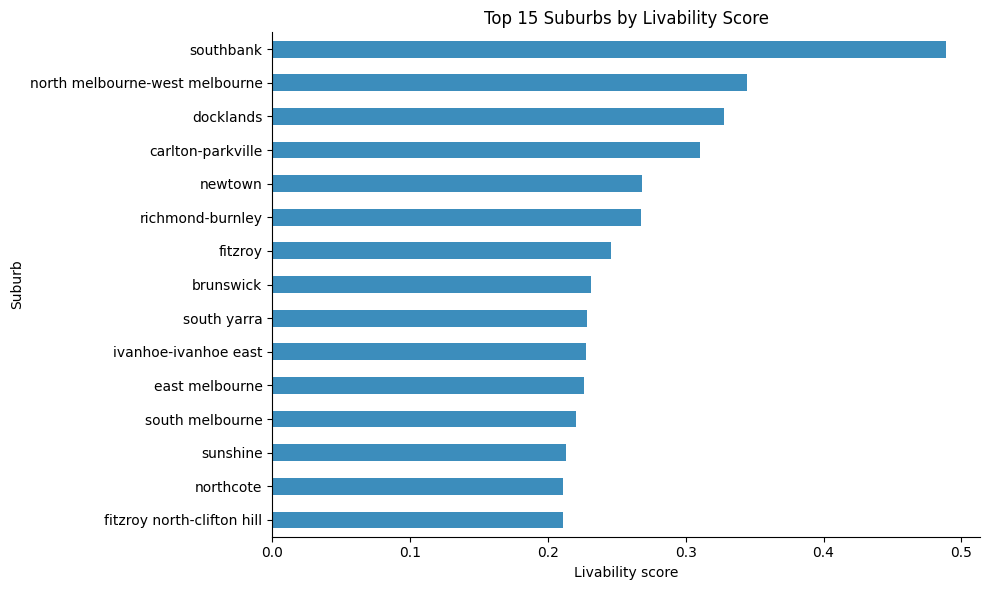

In [115]:
import matplotlib.pyplot as plt

top_n = 15
plot_df = suburb_df.dropna(subset=["livability_score"]).head(top_n)

if plot_df.empty:
    print("No livability scores available to plot.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    (
        plot_df.sort_values("livability_score")
                .plot(
                    kind="barh",
                    y="livability_score",
                    ax=ax,
                    color="#3C8DBC",
                    legend=False,
                )
    )
    ax.set_xlabel("Livability score")
    ax.set_ylabel("Suburb")
    ax.set_title(f"Top {len(plot_df)} Suburbs by Livability Score")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.tight_layout()
    plt.show()


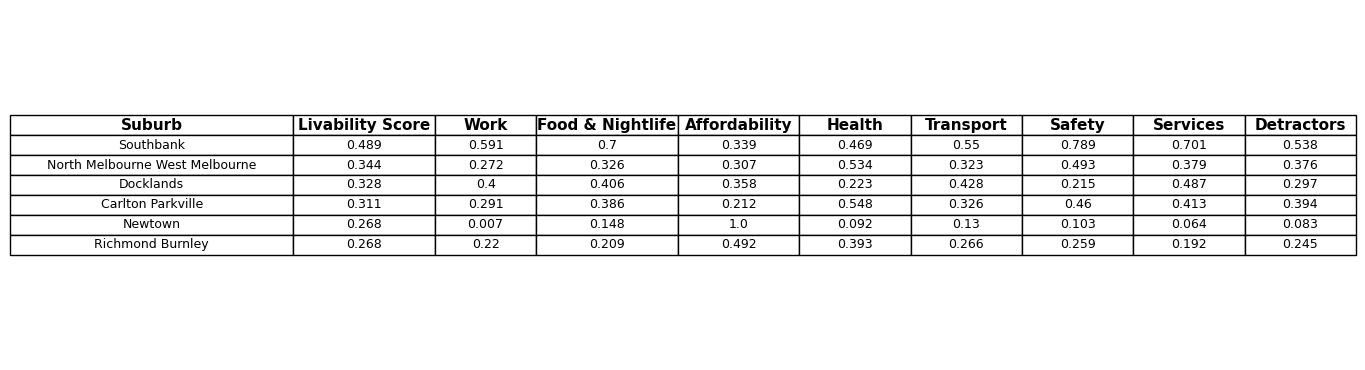

In [117]:
from pathlib import Path
import matplotlib.pyplot as plt

top6 = (
    suburb_df.reset_index()
             .loc[:, ["suburb", "livability_score",
                      "pillar_w", "pillar_e", "pillar_c", "pillar_h",
                      "pillar_t", "pillar_s", "pillar_sv", "pillar_n"]]
             .head(6)
)

top6["suburb"] = top6["suburb"].str.replace("-", " ").str.title()
top6 = top6.rename(columns={
    "suburb": "Suburb",
    "livability_score": "Livability Score",
    "pillar_w": "Work",
    "pillar_e": "Food & Nightlife",
    "pillar_c": "Affordability",
    "pillar_h": "Health",
    "pillar_t": "Transport",
    "pillar_s": "Safety",
    "pillar_sv": "Services",
    "pillar_n": "Detractors",
})

fig, ax = plt.subplots(figsize=(14, 3.8))  # wider canvas
ax.axis("off")

col_widths = [0.28, 0.14, 0.10, 0.14, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11]
table = ax.table(
    cellText=top6.round(3).values,
    colLabels=top6.columns,
    cellLoc="center",
    loc="center",
    colWidths=col_widths,
)

table.auto_set_font_size(False)
for (row, col), cell in table.get_celld().items():
    cell.set_fontsize(9 if row else 11)
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()

out_path = Path("data/curated/rent_features/top6_livability.png")
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, dpi=300, bbox_inches="tight")
